In [1]:
import xgboost
print(xgboost.__version__)

1.7.3


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')


In [38]:
df = pd.read_csv('../data/train.csv')
data = pd.read_csv('../data/test.csv')

df = df.drop('id', axis=1)
data = data.drop('id', axis=1)
print(df['class'].value_counts())
df.head(3)

class
p    1705396
e    1411549
Name: count, dtype: int64


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w


In [43]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

class SafeLabelEncoder(LabelEncoder):
    def __init__(self):
        super().__init__()
        self.classes_ = np.array([])

    def fit(self, y):
        y = y.astype(str)
        self.classes_ = np.unique(y)
        return self

    def transform(self, y):
        y = y.astype(str)
        # 새롭게 등장한 카테고리(클래스)에 대해 -1을 반환
        return np.array([self._safe_transform(val) for val in y])

    def _safe_transform(self, val):
        if val in self.classes_:
            return np.where(self.classes_ == val)[0][0]
        else:
            # 새로운 데이터에 대해 -1을 반환
            return -1

    def fit_transform(self, y):
        return self.fit(y).transform(y)

In [44]:
Pass = set(['cap-diameter' , 'stem-height' , 'stem-width' , 'class'])
le = SafeLabelEncoder()
for key in df.columns:
    print(key)
    if key in Pass : continue
    le.fit(df[key])
    df[key] = le.transform(df[key])  
    data[key] = le.transform(data[key])
df['class'] = le.fit_transform(df['class'])
y = df['class']
X = df.drop('class', axis=1)
print(y.value_counts())

class
cap-diameter
cap-shape
cap-surface
cap-color
does-bruise-or-bleed
gill-attachment
gill-spacing
gill-color
stem-height
stem-width
stem-root
stem-surface
stem-color
veil-type
veil-color
has-ring
ring-type
spore-print-color
habitat
season
class
1    1705396
0    1411549
Name: count, dtype: int64


In [45]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=156)
X_train , X_eval , y_train , y_eval = train_test_split(X , y , test_size=0.1 , random_state=156)
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)
deval = xgb.DMatrix(data=X_eval , label=y_eval)

In [46]:
params = {
    'max_depth' : 3,
    'eta' : 0.05, #learning_rate
    'objective' : 'binary:logistic', #이진 분류
    'eval_metric' : 'logloss' #loss 에 log를 씌운 값
}
num_rounds = 400 #몇 번 반복해서 학습 시킬 것인가

eval_list = [(dtrain , 'train') , (deval , 'eval')]

xgb_model = xgb.train(params=params , dtrain = dtrain , num_boost_round=num_rounds , early_stopping_rounds=50 , evals = eval_list)



[0]	train-logloss:0.68607	eval-logloss:0.68612
[1]	train-logloss:0.67958	eval-logloss:0.67967
[2]	train-logloss:0.67292	eval-logloss:0.67302
[3]	train-logloss:0.66588	eval-logloss:0.66598
[4]	train-logloss:0.66050	eval-logloss:0.66064
[5]	train-logloss:0.65559	eval-logloss:0.65573
[6]	train-logloss:0.64897	eval-logloss:0.64907
[7]	train-logloss:0.64333	eval-logloss:0.64344
[8]	train-logloss:0.63901	eval-logloss:0.63914
[9]	train-logloss:0.63505	eval-logloss:0.63520
[10]	train-logloss:0.63161	eval-logloss:0.63177
[11]	train-logloss:0.62847	eval-logloss:0.62862
[12]	train-logloss:0.62559	eval-logloss:0.62574
[13]	train-logloss:0.62294	eval-logloss:0.62310
[14]	train-logloss:0.62051	eval-logloss:0.62066
[15]	train-logloss:0.61758	eval-logloss:0.61770
[16]	train-logloss:0.61473	eval-logloss:0.61483
[17]	train-logloss:0.61268	eval-logloss:0.61279
[18]	train-logloss:0.60862	eval-logloss:0.60868
[19]	train-logloss:0.60670	eval-logloss:0.60675
[20]	train-logloss:0.60267	eval-logloss:0.60270
[2

In [47]:
pred_probs = xgb_model.predict(dtest)
preds = [1 if x > 0.5 else 0 for x in pred_probs]

preds[:5]

[1, 1, 1, 1, 0]

In [48]:
from sklearn.metrics import confusion_matrix , accuracy_score 
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import f1_score , roc_auc_score

def get_clf_eval(y_test , pred , pred_probs):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precsision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test , pred_probs)
    print("오차행렬")
    print(confusion)
    print("정확도 :", accuracy)
    print("정밀도 :", precsision )
    print("재현율 :", recall)
    print("F1 :", f1)
    print("AUC :", roc_auc)


In [49]:
get_clf_eval(y_test , preds , pred_probs)

오차행렬
[[272224   9981]
 [ 16459 324725]]
정확도 : 0.9575866754145486
정밀도 : 0.9701797995853078
재현율 : 0.9517591680735322
F1 : 0.9608812084806699
AUC : 0.9883708302149281


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

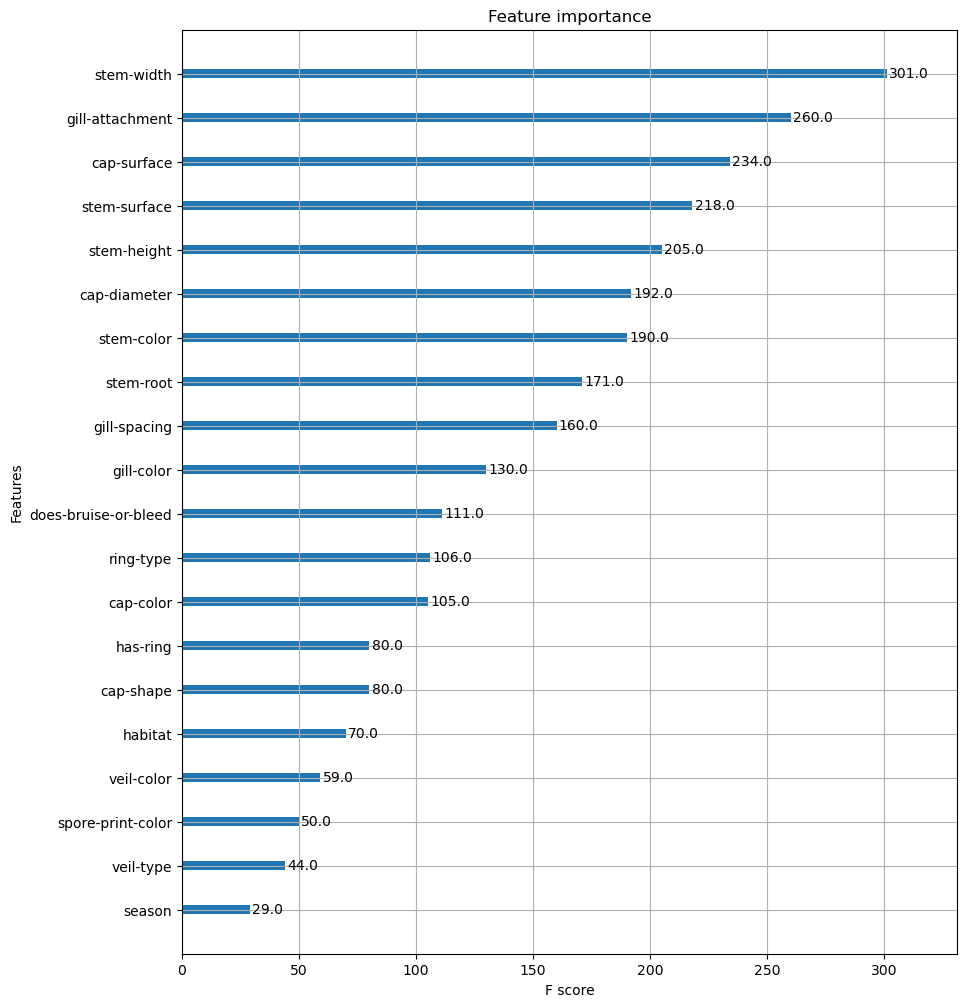

In [50]:
import matplotlib.pyplot as plt 
%matplotlib inline 
fig , ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model , ax=ax)

In [52]:
data = xgb.DMatrix(data=data)
pred_probs = xgb_model.predict(data)
preds = [1 if x > 0.5 else 0 for x in pred_probs]

In [53]:
id= pd.read_csv('../data/test.csv')['id']

In [55]:
with open("result.csv", "w") as f2:
    f2.write("id,class\n")
    for i , p in zip(id , preds):
      
      if p == 1:
        f2.write(f"{i},p\n")
      else:
        f2.write(f"{i},e\n")